In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df_ab = pd.read_csv("listings.csv").copy()
drop_cols = ['id','name','host_id','host_name','last_review','license']
df_ab.drop(columns=drop_cols, inplace=True)

num_feats = ['price','minimum_nights','number_of_reviews',
             'reviews_per_month','availability_365',
             'calculated_host_listings_count']
X_ab = df_ab[num_feats].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ab)

In [4]:
best_score = -1
best_params = {}
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [5, 10]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)
        # need at least 2 clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters}

print("Best DBSCAN params:", best_params)
print("Best DBSCAN sil score:", best_score)

Best DBSCAN params: {'eps': 2.0, 'min_samples': 5, 'n_clusters': 3}
Best DBSCAN sil score: 0.7582245918662814


In [5]:
db = DBSCAN(eps=2.0, min_samples=5)
labels_db = db.fit_predict(X_scaled)
unique, counts = np.unique(labels_db[labels_db >= 0], return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("DBSCAN cluster coun:", cluster_counts)

#confirm
from sklearn.metrics import silhouette_score
sil_confirm = silhouette_score(X_scaled, labels_db)
print(f"Confirmed Sil score for DBSCAN: {sil_confirm:.4f}")

DBSCAN cluster coun: {np.int64(0): np.int64(9632), np.int64(1): np.int64(12), np.int64(2): np.int64(36)}
Confirmed Sil score for DBSCAN: 0.7582


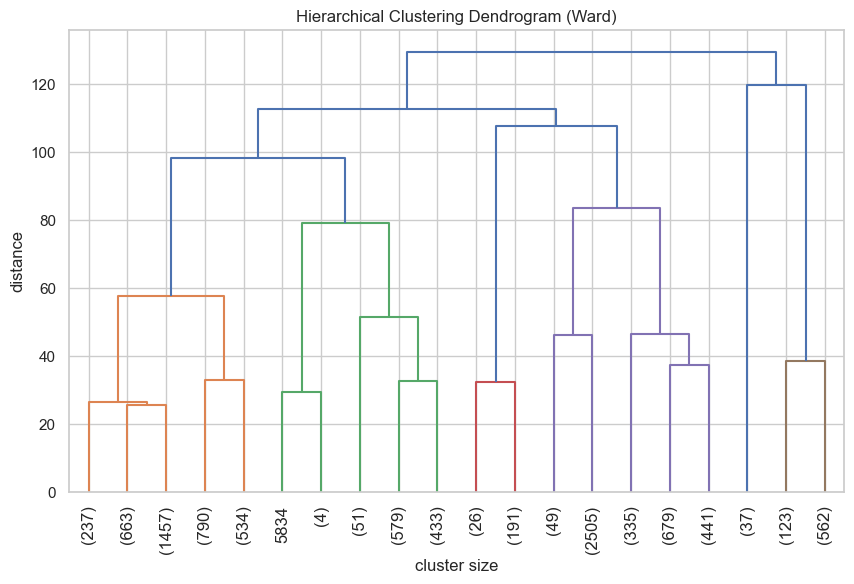

In [6]:
linked = linkage(X_scaled, method='ward')
plt.title('Hierarchical Clustering Dendrogram (Ward)')
dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90.)
plt.xlabel('cluster size')
plt.ylabel('distance')
plt.show()

In [8]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)

agg_score = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative clustering sillhouette score: {agg_score:.4f}")

Agglomerative clustering sillhouette score: 0.4212


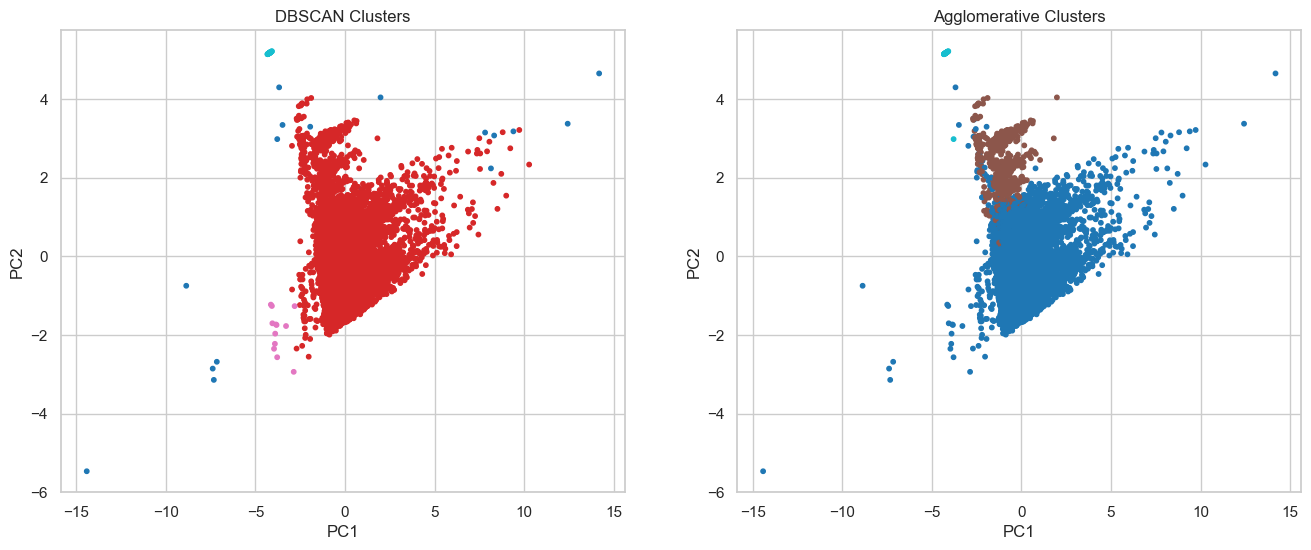

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap='tab10', s=10)
axes[0].set_title('DBSCAN Clusters') 
axes[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, cmap='tab10', s=10)
axes[1].set_title('Agglomerative Clusters')
for ax in axes:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
plt.show()


- scaled six numeric features (price, minimum_nights, number_of_reviews, reviews_per_month, availability_365, calculated_host_listings_count) before clustering.
- DBSCAN tuning(eps=2.0, min_samples=5) produced 3 clusters (sizes: 9,632; 12; 36) and a silhouette score of 0.7582.
- Hierarchical Clustering (Ward linkage, n_clusters=3) achieved a silhouette score of 0.4212, indicating reasonable but looser separation than DBSCAN.
- The dendrogram shows clear splits at three clusters, validating both unsupervised approaches.
- PCA plots confirm that DBSCAN isolates dense vs. sparse listing groups and that Agglomerative clustering roughly recovers similar structures.
- EDA insight: Availability and review activity (reviews_per_month) drive cluster distinctions more than price alone.
- Overfitting control: Silhouette based validation and dendrogram inspection prevented over r under clustering.